In [1]:
from analysis_utils import get_threshold, resize_tiff_image, resize_hdf_image, compute_similarity_matrix, get_augmented_coordinates, display_tiff_image_grid, get_resized_volume, get_resized_ground_truth
from setup import neurotransmitters, model_size, device, feat_dim, resize_size, curated_idx, few_shot_transforms, model, embeddings_path
from setup import np, plt, torch, Trans, torchvision, tqdm, sns, os, h5py
from perso_utils import get_fnames, load_image
from DINOSim import DinoSim_pipeline
from napari_dinosim.utils import get_img_processing_f
%matplotlib inline

Device: cpu


Using cache found in /Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/tomw/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


Model loaded


In [2]:
few_shot = DinoSim_pipeline(model,
                            model.patch_size,
                            device,
                            get_img_processing_f(resize_size),
                            feat_dim, 
                            dino_image_size=resize_size
                            )

files, labels = zip(*get_fnames()) 


In [3]:
resize_factor = resize_size/130
resize = lambda x: resize_factor*x

emb_labels = np.hstack([[neuro]*feat_dim*600 for neuro in neurotransmitters]).reshape(-1) # FIXME: LOOKS WEIRD

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Extracting reference data

In [4]:
l = ['A','D','Ga','Glu','O','S']

indices = [
    [1,3,6,8,9],
    [1,2,4,5,6],
    [0,1,2,4,5],
    [1,2,3,6,7],
    [1,2,5,6,8],
    [0,6,10,11,14]
    ]

coords = [
    [(69,63.5),(68,61),(83,57),(76,62),(60,63)],
    [(66,62),(58.5,64),(64,60),(62.5,65),(64,71)],
    [(65,67),(72,60),(63,72),(60,67),(69,66.5)],
    [(65,66),(64,71),(62,58.5),(62,68),(69,55)],
    [(66,60),(60,70),(61,66.6),(58.5,63.5),(62.5,70.5)],
    [(63,73),(58,69),(60,69),(66,64),(62,71)]
    ]

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute Reference Embeddings

In [5]:
def compute_ref_embeddings(saved_ref_embeddings=False, 
                           embs_path=None, 
                           k=10,
                           data_aug=False):

    if saved_ref_embeddings:
        
        mean_ref = torch.load(embs_path)
        return mean_ref

    else:

        if data_aug:    
            nb_transformations = len(few_shot_transforms)
            
            # Preload images and metadata once
            good_images = []
            transformed_coordinates = []

            for idx in curated_idx:
                img, coord_x, coord_y = load_image(files[idx])
                good_images.append(img.transpose(1,2,0))
                transformed_coordinates.append([(0, coord_x, coord_y)] * nb_transformations)

            transformed_images = []
            for image in good_images:
                transformed = [t(image).permute(1,2,0) for t in few_shot_transforms]
                transformed_images.extend(transformed)

            for j, img in enumerate(transformed_images):
                if img.shape != torch.Size([130, 130, 1]):
                    h, w = img.shape[:2]
                    h_diff = (130 - h) // 2
                    w_diff = (130 - w) // 2
                    padded_img = torch.zeros(130, 130, 1)
                    padded_img[h_diff:h+h_diff, w_diff:w+w_diff, :] = img
                    transformed_images[j] = padded_img
                    
            batch_size = int(len(curated_idx)/len(neurotransmitters)*nb_transformations) # nb of images in per class
            good_datasets = [transformed_images[i:i+batch_size] for i in range(0,len(transformed_images),batch_size)]
            good_datasets = np.array(good_datasets)
            
            transformed_coordinates = np.vstack(transformed_coordinates)
            good_coordinates = [transformed_coordinates[i:i+batch_size] for i in range(0,len(transformed_coordinates),batch_size)]

        else:
            ref_embs_list = []
            for i, index in tqdm(enumerate(indices)):
                dataset_slice = files[i*600:(i+1)*600]
                imgs = [resize_hdf_image(load_image(dataset_slice[k])[0]) for k in index]
                coordinates = [list(map(resize, c)) for c in coords[i]]
                dataset = list(zip(imgs, coordinates))
                class_wise_embs_list = []
                for image, reference in dataset:
                    few_shot.pre_compute_embeddings(
                        image[None,:,:,:],
                        verbose=False,
                        batch_size=1
                    )
                    few_shot.set_reference_vector(get_augmented_coordinates(reference), filter=None)
                    closest_embds = few_shot.get_k_closest_elements(k=k, return_indices=False) # list of vectors
                    class_wise_embs_list.append(torch.mean(closest_embds, dim=0)) # list of lists of vectors
                ref_embs_list.append(class_wise_embs_list) # list of lists of lists of vectors

            ref_embs = np.array([np.mean(class_closest_embs, axis=0) for class_closest_embs in ref_embs_list])
            
            ref_embs_np = ref_embs.cpu().numpy() if isinstance(ref_embs, torch.Tensor) else ref_embs
        
            torch.save(ref_embs_np, os.path.join(embeddings_path, f'{model_size}_mean_ref_{resize_size}_Aug={data_aug}_k={k}'))
            return ref_embs

In [6]:
mean_refs = compute_ref_embeddings()

0it [00:00, ?it/s]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


1it [00:02,  2.59s/it]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


2it [00:05,  2.51s/it]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


3it [00:07,  2.49s/it]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


4it [00:09,  2.49s/it]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


5it [00:12,  2.48s/it]

Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings
Precomputing embeddings


6it [00:14,  2.49s/it]


------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# Compute Datasetwide Embeddings


## w/o Generator

In [7]:
def compute_embeddings(saved_embeddings=False,
                       embs_path=None):

        if saved_embeddings:
                dataset_embeddings = torch.load(embs_path)

        else:
                files, _ = zip(*get_fnames()) 
                dataset_embeddings = []
                for file in files[:5]:
                        with h5py.File(file) as f:
                                volume = f['volumes/raw'][:][np.newaxis,:,:,:]
                                volume_embeddings = []
                                for z in range(volume.shape[-1]):
                                        resized_slice = resize_hdf_image(volume[:,:,:,z])
                                        few_shot.pre_compute_embeddings(
                                                resized_slice,
                                                batch_size=1
                                                )
                                        slice_embedding = few_shot.get_embeddings(reshape=False)
                                        volume_embeddings.append(slice_embedding)
                        dataset_embeddings.append(np.array(volume_embeddings))

                dataset_embeddings = np.array(dataset_embeddings)
                torch.save(dataset_embeddings, os.path.join(embeddings_path, f'{model_size}_dataset_embeddings_{resize_size}'))
        
        return dataset_embeddings

In [8]:
#dataset_embeddings = compute_embeddings()

In [9]:
def compute_predictions(embeddings: np.array, reference_embeddings, proportion):
    
    flattened_embeddings = embeddings.ravel()
    assert emb_labels.shape == flattened_embeddings.shape
    
    similarity_list = []
    for i, embedding in tqdm(enumerate(flattened_embeddings)):
        neuro_class = emb_labels[i]
        reference_index = neurotransmitters.index(neuro_class)
        reference_vector = reference_embeddings[reference_index]
        cosine_similarity = np.dot(reference_vector, embedding)/(np.linalg.norm(reference_vector)*np.linalg.norm(embedding))
        similarity_list.append(cosine_similarity)
    
    similarity_tensor = np.array(similarity_list).reshape(embeddings.shape)
    
    pred_tensor = []
    for volume in similarity_tensor:
        threshold = get_threshold(volume, proportion)
        pred = volume > threshold
        pred = pred.astype(np.uint8)
        pred_tensor.append(pred)
    
    pred_tensor
    
    for embedding in embeddings:
        flattened_volume = embedding.reshape(-1)
        similarity_list = [np.dot(reference, patch)/(np.linalg.norm(reference)*np.linalg.norm(patch)) for patch in flattened_volume]
        similarity_matrix = np.array(similarity_list).reshape(embedding.shape)
        threshold = get_threshold(similarity_matrix, proportion)
        pred = similarity_matrix > threshold
        pred = pred.astype(np.uint8)
        pred_tensor.append(pred)
    return pred_tensor

## w/ Generator

In [ ]:
def get_prediction(saved_embeddings=False,
                    embs_path=None,
                    reference_embeddings=None,
                    proportion=0.95):

        if saved_embeddings:
                dataset_embeddings = torch.load(embs_path)

        else:

                files, _ = zip(*get_fnames()) 
                for file in files:
                        with h5py.File(file) as f:
                                volume = f['volumes/raw'][:]
                                '''
                                volume_embeddings = []
                                for z in tqdm(range(volume.shape[-1])):
                                        resized_slice = resize_hdf_image(volume[None,:,:,z])
                                        
                                        few_shot.pre_compute_embeddings(
                                                resized_slice[None,...],
                                                batch_size=1,
                                                verbose=False
                                                )
                                        slice_embedding = few_shot.get_embeddings(reshape=False)
                                        volume_embeddings.append(slice_embedding)
                                '''
                                few_shot.pre_compute_embeddings(
                                                volume[None,...].transpose(3,1,2,0),
                                                batch_size=30,
                                                verbose=True
                                                )
                                volume_embeddings = few_shot.get_embeddings(reshape=False)
                                volume_embeddings = np.array(volume_embeddings)

                                flattened_volume_embeddings = volume_embeddings.reshape(-1, feat_dim)
                                path = os.path.normpath(file)
                                neuro_class = path.split(os.sep)[-2] 

                                reference_index = neurotransmitters.index(neuro_class)
                                reference_vector = reference_embeddings[reference_index]
                                cosine_similarities = [np.dot(reference_vector, embedding)/(np.linalg.norm(reference_vector)*np.linalg.norm(embedding)) for embedding in tqdm(flattened_volume_embeddings, desc='Computing similarities')]
                                similarity_volume = np.array(cosine_similarities).reshape(volume_embeddings.shape[:3])

                                threshold = get_threshold(similarity_volume, proportion)
                                pred = similarity_volume > threshold
                                pred = pred.astype(np.uint8)

                                yield pred

In [11]:
prediction_generator = get_prediction(reference_embeddings=mean_refs)

In [12]:
preds = next(prediction_generator)

Precomputing embeddings


100%|██████████| 5/5 [01:09<00:00, 13.83s/it]
/var/folders/nd/k2k1v8713rb4g77z7z6mbxn80000gn/T/ipykernel_4096/3329048448.py:34: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  volume_embeddings = np.array(volume_embeddings)


(130, 37, 37, 384)


Computing similarities: 100%|██████████| 177970/177970 [00:00<00:00, 217431.41it/s]


75


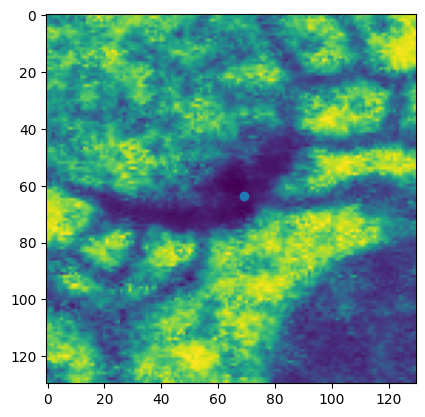

In [28]:
with h5py.File(files[0]) as f:
        pre, _ = f['annotations/locations'][:]/8
        x, y, z = pre.astype(int)
        slice_volume = f['volumes/raw'][:][np.newaxis,:,:,z]
plt.imshow(slice_volume.transpose(1,2,0))
plt.scatter(coords[0][0][0], coords[0][0][1])
print(z)

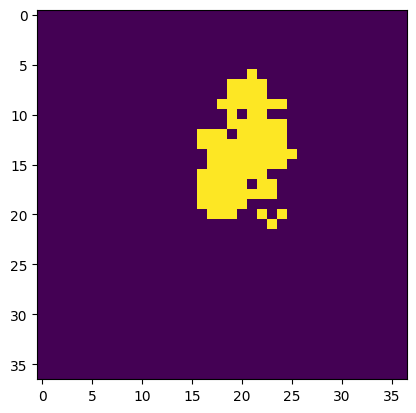

In [25]:
plt.imshow(preds[75])

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
from tifffile import imread
img = imread('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/EM_Data_copy/original/test/x/frarobo_conn_18925456_images.tif')[6]
resized_image = resize_tiff_image(img)

resize_factor = np.multiply([resize_size, resize_size], 1/np.array(img.shape))
coordinates = (resize_factor[0] * 153, resize_factor[1] * 131.5)
aug_coordinates = get_augmented_coordinates(coordinates)

few_shot.pre_compute_embeddings(
    dataset=resized_image[None,:,:,:], 
    batch_size=1
    )
embeddings = few_shot.get_embeddings(reshape=False)

few_shot.set_reference_vector(aug_coordinates)
reference = few_shot.get_reference_embedding()

# Generate ground-truth

In [ ]:
import os
path = '/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/EM_Data_copy/original/test'
x = sorted(os.listdir(os.path.join(path, 'x')), key=os.path.basename)
y = sorted(os.listdir(os.path.join(path, 'y')), key=os.path.basename)

In [ ]:
from tifffile import imread
test_volume = get_resized_volume('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/EM_Data_copy/original/test/x/frarobo_conn_18925456_images.tif')

nb_slices = test_volume.shape[0]

few_shot.pre_compute_embeddings(
    dataset=test_volume, 
    batch_size=nb_slices
    )
new_embeddings = few_shot.get_embeddings(reshape=False)

similarity_tensor = []
for i in tqdm(range(nb_slices)):
    similarity = compute_similarity_matrix(reference, new_embeddings[i])
    similarity_tensor.append(similarity)
    
similarity_tensor = np.array(similarity_tensor)

threshold = get_threshold(similarity_tensor[6], 0.95)
pred = similarity_tensor > threshold
pred = pred.astype(np.uint8)

In [ ]:
gt = get_resized_ground_truth('/Users/tomw/Documents/MVA/Internship/Cambridge/Datasets/EM_Data_copy/original/test/y/frarobo_conn_18925456_masks.tif').squeeze()

In [ ]:
from sklearn.metrics import jaccard_score

score = jaccard_score(gt.ravel(), pred.ravel())
print(score)